# Proyecto final grupo 7: Clasificación binaria (aprobar o denegar préstamos)
Realizada por:
- Jaime Benedí
- Miguel Sevilla

Objetivo : Predecir si un préstamo será pagado en su totalidad o terminará en impago, ayudando a la toma de decisiones de la SBA o de la entidad financiera.

## Librerías a usar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

## Importar los datos de Kaggle
Asumimos descargados el dataset de Kaggle.

In [2]:
DATASET_PATH : str = './data/SBAnational.csv'
DATA_PATH : str = './data/'
IMAGES_PATH : str = './images/'

In [248]:
original_dataset = pd.read_csv(DATASET_PATH, low_memory=False)

## 1. Análisis del dataset

### ¿Que tipo de problema estamos resolviendo?

Este dataset plantea un problema de **clasificación**. El objetivo es generar un modelo que, considerando unas variables descriptivas del perfil de un futuro préstamo a conceder, ser capaz de predecir si éste será capaz de devolverlo en los plazos establecidos o si es probable que caiga en _default_.

Y esas serán nuestras dos clases: _Charged Off_ o _Paid in Full_, por lo tanto específicamente es un problema de **clasificación binaria**.

Como contexto, el dataset está extraído de la Administración de Pequeños Negocios de EEUU (SBA) sobre la asignación, características y pagos de préstamos entre 1962 y 2014.

### Dimensiones de la población

In [249]:
tamPoblacional = original_dataset.shape[0]
numOriginalVariables = original_dataset.shape[1]

print(f"-- Naturaleza del conjunto original de datos --")
print(f"Número de elementos en la muestra: {tamPoblacional}")
print(f"Número de variables en la muestra: {numOriginalVariables}")

-- Naturaleza del conjunto original de datos --
Número de elementos en la muestra: 899164
Número de variables en la muestra: 27


### Explicación de los atributos

Variables del dataset:

In [250]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

### Variable de salida (dependiente)

#### MIS_Status

Esta será la variable de clasificación que usaremos como salida esperada. La variable es de tipo `str` e indica el estado del préstamo.

In [251]:
original_dataset['MIS_Status'].value_counts()

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

- `P I F` (_Paid In Full_) significa que el préstamo fue pagado correctamente y de manera completa.
- `CHGOFF` (_Charged Off_) (también _default_) significa que el préstamo no fue pagado bajo las condiciones previstas.

Obviamente, al ser la variable que usaremos para clasificar todo el dataset, además de tener dos clases nominales claras, afirmamos que es:

- **categórica**.
- **evaluable para correlación**.

### Variables de entrada (independientes)

#### LoanNr_ChkDgt

Es un identificador del préstamo concreto en un `str`. Clave primaria para distinguir los préstamos entre sí. Para este análisis resulta inútil, puesto que es único para cada elemento, es independiente a la asignación del préstamo y no condiciona el desarrollo del deudor en ninguna manera. Afirmamos que es:

- **identificador**
- **no evaluable**

#### Name

Nombre de la persona (jurídica) deudora en un `str`. Al igual que la categoría anterior, cumple los requisitos para no ser evaluada. Afirmamos que es:

- **identificador**
- **no evaluable**

#### City

Nombre de la ciudad del deudor almacenada en un `str`. Observamos la cantidad de valores distintos que existen en el dataset:

In [252]:
original_dataset['City'].value_counts()

LOS ANGELES                       11558
HOUSTON                           10247
NEW YORK                           7846
CHICAGO                            6036
MIAMI                              5594
                                  ...  
EL DORADO SPRINGS (ELDORADO SP        1
HUNTINDON                             1
LEBAHON                               1
WILLOW RIVER                          1
SO. OZONE PARK                        1
Name: City, Length: 32581, dtype: int64

Existen muchísimas ciudades distintas en el dataset, además que en un primer vistazo parece que la distribución de préstamos por ciudad parece muy concentrada en núcleos densos de población.

Existe una manera de agrupar ciudades: por los estados a los que pertenece, reduciendo el máximo de clases que pueden expandirse hasta 51. El problema es que ya existe una variable que hace eso. Creemos que esta es más información personal del deudor que de la naturaleza de préstamos repartidos a nivel nacional.

No la consideramos que vaya a ser evaluable.

- **categórica**
- **no evaluable**

#### State

Iniciales de los estados (EEUU) de los deudores en un `str`. Máximo 51

In [253]:
aux = original_dataset['State'].value_counts()
print(aux)
print(aux.shape[0])

CA    130619
TX     70458
NY     57693
FL     41212
PA     35170
OH     32622
IL     29669
MA     25272
MN     24373
NJ     24035
WA     23263
GA     22277
WI     21040
MO     20678
CO     20605
MI     20545
UT     18776
AZ     17631
NC     14294
IN     14132
MD     13269
VA     13264
CT     12229
NH     12109
IA     11996
KS     11464
OR     11051
OK      9950
LA      9576
ID      9498
TN      9403
RI      9028
MT      8749
AL      8362
NV      8024
KY      7723
MS      7686
NE      6386
AR      6341
NM      6033
ME      5944
SC      5597
VT      5454
ND      5245
SD      4431
HI      3610
WV      3287
WY      2839
AK      2405
DE      2220
DC      1613
Name: State, dtype: int64
51


Aquí las clases están acotadas a un máximo de 51, que es más razonable que la de ciudades y, a primera vista parece que está mejor distribuido que en el casos de ciudades.

- **categórica**
- **evaluable para correlación**

#### Zip

Código que representa el código postal asociado a una tarjeta de crédito o a la cuenta en la que se deposita el préstamo. Es un identificador al que no le daremos ninguna importancia porque solo sirve para asociar préstamos con cuentas bancarias y códigos bancarios. Almacenado en `str`

- **identificador**
- **no evaluable**

#### Bank

Nombre del banco asociado al préstamo, almacenado en un `str`. Observamos el número de bancos considerados en el dataset

In [254]:
original_dataset['Bank'].value_counts()

BANK OF AMERICA NATL ASSOC        86853
WELLS FARGO BANK NATL ASSOC       63503
JPMORGAN CHASE BANK NATL ASSOC    48167
U.S. BANK NATIONAL ASSOCIATION    35143
CITIZENS BANK NATL ASSOC          35054
                                  ...  
FIRST LANDMARK BANK                   1
MASON CITY NATIONAL BANK              1
FARMERS ST. BK OF CAMP POINT          1
CAPITAL BANK CORPORATION              1
DEPCO                                 1
Name: Bank, Length: 5802, dtype: int64

Observamos 5802 categorías. Es un número muy alto para clasificar un dataset. Además observamos inicialmente que la distribución es inicialmente con deudores correspondientes a bancos de los que nadie más proviene. Para tomar en consideración esta variable, deberíamos quitar todos estos bancos y deudores; o podríamos considerar el estado al que pertenecen dichos bancos como agrupación superior, puesto que que saldrán menos categorías (la siguiente variable). Asumimos que en términos de mercado y economía, si tiene relevancia por el porcentaje de préstamos que toma, pero no sabemos cuál sería el efecto en el objetivo de la práctica.

- **categórica**
- **no evaluable**

#### BankState

Iniciales del estado al que pertenece, almacenado en un `str`. Observamos su distribución:

In [255]:
aux = original_dataset['BankState'].value_counts()
print(aux)
print(aux.shape[0])

CA    118116
NC     79514
IL     65908
OH     58461
SD     51095
TX     47790
RI     45366
NY     39592
VA     29002
DE     24537
MN     19960
UT     18997
PA     17081
WI     15416
MO     14861
MA     13913
GA     13812
FL     13810
AL     12134
OR     11374
WA     10693
CO     10582
CT      9917
IA      9866
NJ      9436
KS      8876
MT      7860
IN      7623
SC      7472
MI      7369
OK      7326
MD      7016
NH      6807
AR      6322
MS      5942
TN      5620
NE      5337
ND      5113
LA      5062
VT      4757
NM      4422
KY      4382
NV      4325
ID      4314
DC      4003
AZ      3957
ME      3691
HI      2991
WY      2168
WV      2007
AK      1439
PR       156
GU         5
AN         1
EN         1
VI         1
Name: BankState, dtype: int64
56


Sorprendente salen 56 valores en vez de 51. Asumimos la existencia de bancos extranjeros, de momento.

El dataset queda clasificado de manera más simple. Además, se puede relacionar la proveniencia del deudor con la proveniencia del banco, puesto que quedan simplificados en categorías similares y no tienen que ser las mismas.

- **categórica**
- **evaluable para correlación**

#### NAICS

_North America Industry Classification System (NAICS)_ es un código que comprime información sobre la empresa (deudor). La primera observación resulta:

In [256]:
original_dataset['NAICS'].value_counts()

0         201948
722110     27989
722211     19448
811111     14585
621210     14048
           ...  
927110         1
327410         1
314992         1
922110         1
325192         1
Name: NAICS, Length: 1312, dtype: int64

Observamos muchas clases y el entendimiento del código es complejo. Sin embargo, consideramos importante interpretar que tipo de empresa está pidiendo un préstamo. En las guías del dataset, se explica que los dos primeros dígitos del código corresponde al campo/tipo de negocio que pertenece la empresa.
La nueva clasificación que seguiría sería:

In [257]:
tipos_industria ={
    '11' : 'Agricultura, Silvicultura, Pesca y Caza',
    '21' : 'Mineria, Canteras y Extraccion de Petroleo y Gas',
    '22' : 'Servicios Publicos',
    '23' : 'Construccion',
    '31' : 'Manufactura',
    '32' : 'Manufactura',
    '33' : 'Manufactura',
    '42' : 'Comercio Mayorista',
    '44' : 'Comercio Minorista',
    '45' : 'Comercio Minorista',
    '48' : 'Transporte y Almacenamiento',
    '49' : 'Transporte y Almacenamiento',
    '51' : 'Informacion',
    '52' : 'Finanzas y Seguros',
    '53' : 'Inmuebles y Alquileres',
    '54' : 'Servicios Profesionales, Cientificos y Tecnicos',
    '55' : 'Servicios de Gestion de Empresas',
    '56' : 'Gestion de Residuos y Servicios de Descontaminacion',
    '61' : 'Servicios Educativos',
    '62' : 'Servicios de Salud y Asistencia Social',
    '71' : 'Artes, Entretenimiento y Recreacion',
    '72' : 'Restaurantes y Hosteleria',
    '81' : 'Otros servicios (excepto Administracion Publica)',
    '92' : 'Administracion Publica'
}

abreviaturas_tipos_industria = {
    '11' : 'ASPC',
    '21' : 'MCE',
    '22' : 'SP',
    '23' : 'Construccion',
    '31' : 'Manufactura',
    '32' : 'Manufactura',
    '33' : 'Manufactura',
    '42' : 'Mayorista',
    '44' : 'Minorista',
    '45' : 'Minorista',
    '48' : 'Logistica',
    '49' : 'Logistica',
    '51' : 'Info',
    '52' : 'Seguros',
    '53' : 'Inmuebles',
    '54' : 'STEM',
    '55' : 'Gestion',
    '56' : 'Residuos',
    '61' : 'Educacion',
    '62' : 'Salud',
    '71' : 'Artes',
    '72' : 'Turismo',
    '81' : 'Otros',
    '92' : 'AP'
}

Los cuales son una muy buena clasificación del dataset, con el coste de tener que pre-procesarlo.

- **categórica**
- **evaluable para correlación**

#### ApprovalDate

Fecha en la que el organismo SBA, que representa nuestro modelo, ha aprobado la concesión del préstamo. Es un objeto al que habría que aplicar un cast a un tipo fecha.

In [258]:
original_dataset['ApprovalDate'].head(2)

0    28-Feb-97
1    28-Feb-97
Name: ApprovalDate, dtype: object

In [259]:
original_dataset['ApprovalDate'].value_counts()

7-Jul-93     1131
30-Jan-04    1032
8-Jul-93      780
4-Oct-04      658
30-Sep-03     608
             ... 
29-May-75       1
21-Feb-75       1
25-Apr-67       1
12-Apr-72       1
19-Sep-74       1
Name: ApprovalDate, Length: 9859, dtype: int64

Ciertamente el dataset está contextualizado históricamente, pero por simplicidad, muy seguramente en caso de necesitar de que las fechas resulten interesantes para la evaluación del modelo, nos quedemos con el año, más concretamente con la variable siguiente, el año fiscal.

- **continua (fecha)**
- **(no) evaluable**

#### ApprovalFY

Contextualización de la anterior variable en el año fiscal al que pertenecía el préstamo en un `int`.

In [260]:
aux = original_dataset['ApprovalFY'].value_counts()
print(aux)
print('Total de años:', aux.shape[0])

2005     77525
2006     76040
2007     71876
2004     68290
2003     58193
1995     45758
2002     44391
1996     40112
2008     39540
1997     37748
2000     37381
1999     37363
2001     37350
1998     36016
1994     31598
1993     23305
1992     20885
2009     19126
2010     16848
1991     15666
1990     14859
1989     13248
2011     12608
2012      5997
2013      2458
1987      2218
1986      2118
1984      2022
1985      1944
1988      1898
1983      1684
1982       719
1981       630
1980       477
1979       352
2014       268
1978       242
1977       137
1976        66
1973        52
1974        42
1975        30
1972        27
1971        20
1976A       18
1970         8
1969         4
1967         2
1968         2
1965         1
1966         1
1962         1
Name: ApprovalFY, dtype: int64
Total de años: 52


Tenemos mejor agrupado al dataset en base a los 52 años de despligue del dataset y de manera numérica, con una distribución no uniforme, pero tampoco desproporcionadamente incorregible.

- **continua**
- **evaluable para correlación**

#### Term

Entendemos esta variable como el número de meses totales para pagar el préstamo, almacenado en un `int`.

<Axes: >

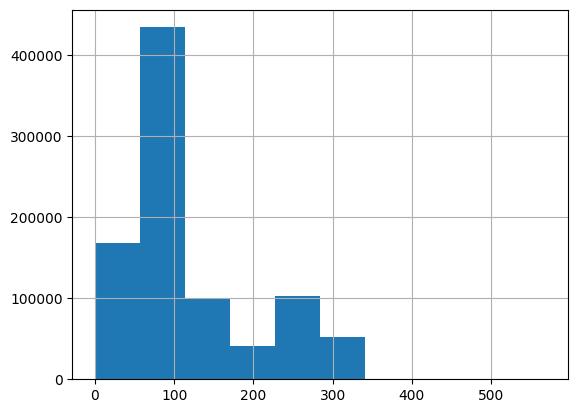

In [261]:
original_dataset['Term'].hist()

La cantidad de tiempo que tenga un deudor para pagar un préstamo, sumado a otros factores, puede ser crucial para la predicción en el problema. Además, la podemos cambiar a días o años si consideráramos.

- **continua**
- **evaluable para correlación**

#### NoEmp

Variable que considera el número de empleados en la empresa, almacenado en un `int`.

<Axes: >

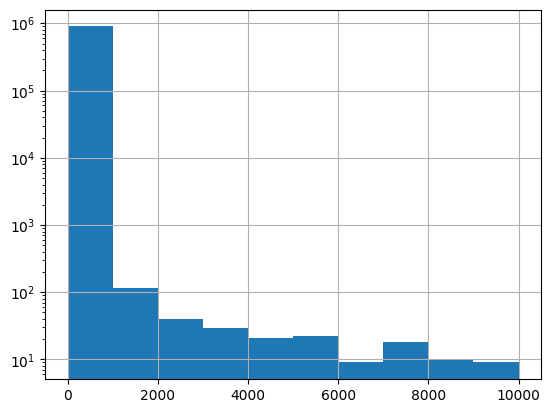

In [262]:
original_dataset['NoEmp'].hist(log=True)

A más empleados, más compleja es la gestión de una empresa, lo cual podemos suponer que podría llegar a afectar con los préstamos.

- **continua**
- **evaluable para correlación**

#### NewExist

Variable que indica si el negocio que pide el préstamo ya existía con más de dos años de antigüedad o si es un negocio creado recientemente (menor o igual a dos años).

- `1` $\rightarrow$ negocio que ya existía
- `2` $\rightarrow$ negocio nuevo

In [263]:
original_dataset['NewExist'].value_counts()

1.0    644869
2.0    253125
0.0      1034
Name: NewExist, dtype: int64

Vemos la aparición del valor `0`. Estos son datos erróneos. Será necesario preprocesar los datos si se considera esta variable.

La veteranía de una empresa puede influir en la gestión del pago de sus deudas. Se considera para evaluación.

- **categórica**
- **evaluable para correlación**

#### CreateJob

Número de puestos de trabajo creados, almacenado en un `int`.

<Axes: >

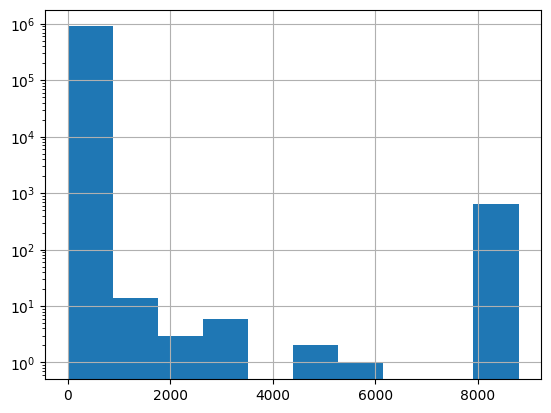

In [264]:
original_dataset['CreateJob'].hist(log=True)

Variable numérica que puede afectar al pago del préstamo como gasto inicial en fuerza social esperado.

- **continua**
- **evaluable para correlación**

#### RetainedJob

Número de puestos de trabajo que se conservan en el tiempo tras la creación. El crecimiento de la empresa medido en trabajadores, almacenado en un `int`.

<Axes: >

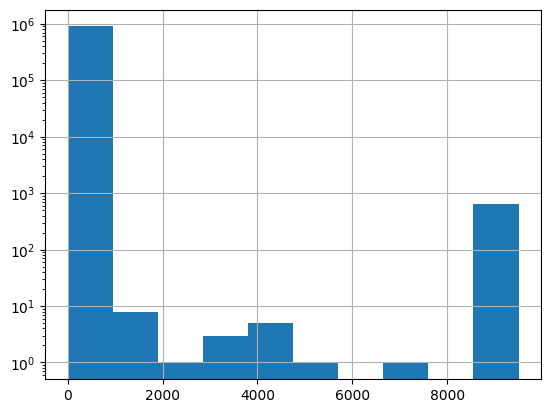

In [265]:
original_dataset['RetainedJob'].hist(log=True)

Está asociado con la variable anterior, así podemos considerarla igualmente para evaluación. Además, podemos asociar y simplificarla con la anterior tal que su relación indique el crecimiento que ha tenido la empresa.

- **continua**
- **evaluable para correlación**

#### FranchiseCode

Código de mínimo cinco dígitos que hace referencia a la franquicia a la que pertenece el negocio (en caso de que forme parte de una franquicia). Cabe destacar que hay dos códigos especiales:

- `"00000"` y `"00001"` $\rightarrow$ Negocio sin franquicia

<Axes: >

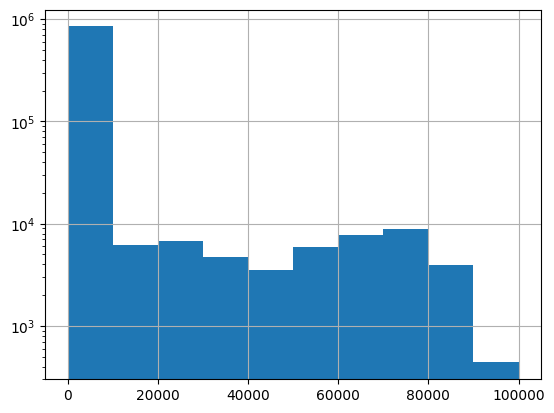

In [266]:
original_dataset['FranchiseCode'].hist(log=True)

Esta es una variable categórica muy dispersa sin interés evaluable dado el número de categorías. Sin embargo puede interesar observar la relación de pertenencia a negocios mayores y la naturaleza de los préstamos y el proceso de pago.

Algo que podremos hacer para simplificar la variable y hacer que sea evaluable es reclasificar todo el dataset en dos categorías:

- Pertenece a una franquicia.
- No pertenece a una franquicia.

Perdemos información por el camino, pero no dejamos de considerar para evaluarla para correlación.

- **categórica**
- **evaluable para evaluación**

#### UrbanRural

Variable `int` que indica la consideración dada al deudor si proviene de un entorno urbano o rural.

In [267]:
original_dataset['UrbanRural'].value_counts()

1    470654
0    323167
2    105343
Name: UrbanRural, dtype: int64

El significado de las categorías son:

- `0` $\rightarrow$ indeterminado
- `1` $\rightarrow$ urbano
- `2` $\rightarrow$ rural

Dado que no queremos evaluar ciudades en particular, esta clasificación puede compensar la pérdida de información sumada con la variable `State`. Sin embargo, tener una clase indeterminada puede acabar haciéndola inútil en la correlación.

- **categórica**
- **evaluable para correlación**

#### RevLineCr

Por simplificar, una línea de crédito revolvente es un tipo especial de préstamo que sigue unas normas concretas. Esta variable `str` indica si el préstamo es de este tipo. Los valores posibles son:

- `Y` (yes)
- `N` (no)

In [268]:
original_dataset['RevLineCr'].value_counts()

N    420288
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: RevLineCr, dtype: int64

Observamos muchos valores ajenos a la clasificación esperada. Estos son considerados como erratas y tendrán que ser procesados, ya que carecemos de una interpretación fehaciente de lo que significan.

Por lo demás, se divide en dataset en dos categorías importantes, por lo que podemos considerar para la evaluación.

- **categórica**
- **evaluable para correlación**

#### LowDoc

_LowDoc Loan_ es otro tipo especial de préstamos considerados en el dataset. Al igual que la variable anterior, los valores posibles son:

- `Y` (yes)
- `N` (no)

In [269]:
original_dataset['LowDoc'].value_counts()

N    782822
Y    110335
0      1491
C       758
S       603
A       497
R        75
1         1
Name: LowDoc, dtype: int64

Observamos muchos valores ajenos a la clasificación esperada. Estos son considerados como erratas y tendrán que ser procesados, ya que carecemos de una interpretación feaciente de lo que significan.

Por lo demás, divide en dataset en dos categorías importantes, por lo que podemos considerar para la evaluación.

- **categórica**
- **evaluable para correlación**

#### ChgOffDate

Variable que indica la fecha en la que el préstamo ha caído en impago.

Puede resultar interesante por `ApprovalDate` y `Term` ya que podemos intentar extraer métricas de hasta cuánto tiempo aguantan los deudores pagando.

- **continua**
- **(no) evaluable para correlación**

#### DisbursementDate

Fecha en la que el deudor recibe el desembolso de los fondos del préstamo, almacenado en un `str`.


In [270]:
original_dataset['DisbursementDate'].value_counts()

31-Jul-95    10371
30-Apr-95    10320
31-Jan-95     9745
31-Oct-94     8890
31-Oct-95     8161
             ...  
30-Jul-14        1
7-Mar-01         1
6-Jul-01         1
10-Feb-01        1
25-Oct-97        1
Name: DisbursementDate, Length: 8472, dtype: int64

Hay muchas fechas, no lo suficiente como para interpretarlo de manera continua como una línea temporal, y demasiadas para clasificarlas categóricamente.

En este punto, nos damos cuenta que hace una diferenciación entre el día cuando se aprueba el préstamo y cuando se recibe el dinero. Consideramos la opción de fusionar `ApprovalDate` y `DisburmentDate` en una única variable que mida la diferencia entre ambas fechas, pues la inmediatez o retraso en recibir el dinero puede afectar en la gestión del pago del préstamo. No tenemos claro la utilidad, pero así evitamos descartar la información temporal de golpe.

- **continua**
- **(no) evaluable**

#### DisbursementGross

Cantidad de dinero en dólares estadounidenses desembolsados. Al ser una divisa asumimos que el dato estará en `float`.

In [271]:
original_dataset['DisbursementGross'].value_counts()

$50,000.00        43787
$100,000.00       36714
$25,000.00        27387
$150,000.00       23373
$10,000.00        21328
                  ...  
$143,118.00           1
$23,827.00            1
$157,338.00           1
$60,698.00            1
$1,086,300.00         1
Name: DisbursementGross, Length: 118859, dtype: int64

In [272]:
original_dataset['DisbursementGross'].dtype

dtype('O')

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La cantidad desembolsada de un préstamo creemos que resulta influyente con respecto a otros factores, por ello la consideraremos para estudio en la correlación.

- **continua**
- **evaluable para correlación**

#### BalanceGross

Indica el importe bruto que falta por pagar en dólares estadounidenses cuando se ha producido el impago.

In [273]:
original_dataset['BalanceGross'].value_counts()

$0.00           899150
$12,750.00           1
$827,875.00          1
$25,000.00           1
$37,100.00           1
$43,127.00           1
$84,617.00           1
$1,760.00            1
$115,820.00          1
$996,262.00          1
$395,476.00          1
$41,509.00           1
$600.00              1
$9,111.00            1
$96,908.00           1
Name: BalanceGross, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

Esta variable sólo afecta después de la clasificación en pago o impago, lo que hace que sea inútil para nuestro estudio.

- **continua**
- **no evaluable**

#### ChgOffPrinGr

Variable que representa dinero de la deuda pendiente que se espera que _no_ se consiga pagar

In [274]:
original_dataset['ChgOffPrinGr'].value_counts()

$0.00           737152
$50,000.00        2110
$10,000.00        1865
$25,000.00        1371
$35,000.00        1345
                 ...  
$29,982.00           1
$568,599.00          1
$142,721.00          1
$893,162.00          1
$124,847.00          1
Name: ChgOffPrinGr, Length: 83165, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

En función de cuánto se descuenta de la deuda, puede afectar al pago del préstamo.

- **continua**
- **evaluable para correlación**

#### GrAppv

Variable que indica la cantidad de dinero que ha concedido el banco respecto al préstamo.

In [275]:
original_dataset['GrAppv'].value_counts()

$50,000.00        69394
$25,000.00        51258
$100,000.00       50977
$10,000.00        38366
$150,000.00       27624
                  ...  
$407,542.00           1
$220,900.00           1
$57,587.00            1
$531,577.00           1
$1,086,300.00         1
Name: GrAppv, Length: 22128, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La variable en sí es informativa, desconocemos cuánto puede informar respecto al objetivo.

- **continua**
- **(no) evaluable para correlación**

#### SBA_Appv

Variable que indica la cantidad garantizada de dinero que ha concedido la SBA respecto al préstamo.

In [276]:
original_dataset['SBA_Appv'].value_counts()

$25,000.00      49579
$12,500.00      40147
$5,000.00       31135
$50,000.00      25047
$10,000.00      17009
                ...  
$192,949.00         1
$212,352.00         1
$57,072.00          1
$32,938.00          1
$715,674.00         1
Name: SBA_Appv, Length: 38326, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La variable en sí es informativa, desconocemos cuánto puede informar respecto al objetivo. Sin embargo, hemos pensado que quizás la relación con la anterior sí pueda ser relevante. Dado que representamos a la SBA, quizás los préstamos sobre los que concedemos más dinero que los bancos son más seguros, o al revés.

- **continua**
- **(no) evaluable para correlación**

## Preprocesado de datos

Descartamos las variables que tenemos garantizado que no usaremos, y eliminamos posibles duplicados

In [277]:
variables_iniciales_descartadas = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BalanceGross']

In [278]:
original_dataset.drop_duplicates()
original_dataset.reset_index(drop=True, inplace=True)
dataset_preprocesado = original_dataset.copy(deep=True).drop(columns=variables_iniciales_descartadas)

Estudiamos las cantidad de valores nulos que hay por variable en el dataset

In [279]:
dataset_preprocesado.isnull().sum()

State                    14
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

Destacamos que la variable `ChgOffDate` contiene datos nulos para un porcentaje muy alto del conjunto de datos. Esto hace que la variable sea inoperable y la tengamos que descartar, puesto que considerarla nos haría quedarnos sin dataset.

Esto se debe a que la varaible solo tiene valores para aquellos préstamos que han caído en impago. Considerarla haría que solo trabajásemos con los valores de una de las clases a clasificar.

In [280]:
dataset_preprocesado = dataset_preprocesado.drop(columns=['ChgOffDate'])

Ahora eliminamos los elementos con valores nulos en alguna de sus columnas:

In [281]:
dataset_preprocesado = dataset_preprocesado.dropna()
valores_nulos = tamPoblacional - dataset_preprocesado.shape[0]
print('Eliminados:', valores_nulos)
dataset_preprocesado.isnull().sum()

Eliminados: 12882


State                0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64

In [282]:
dataset_preprocesado.reset_index(drop=True, inplace=True)

In [283]:
tamPoblacionalSinNulos = dataset_preprocesado.shape[0]
numVariablesSinNulos = dataset_preprocesado.shape[1]

print(f"-- Naturaleza del conjunto de datos preprocesado --")
print(f"Número de elementos en la muestra: {tamPoblacionalSinNulos} ({(-1 + (tamPoblacionalSinNulos/tamPoblacional)):.2%})")
print(f"Número de variables en la muestra: {numVariablesSinNulos}")

-- Naturaleza del conjunto de datos preprocesado --
Número de elementos en la muestra: 886282 (-1.43%)
Número de variables en la muestra: 20


### Formateo de variables

#### Variables con divisa
Adaptamos `DisbursementGross`, `ChgOffPrinGr`, `GrAppv` y `SBA_Appv` para que se detecten como floats. Para ello, tendremos que borrar el "$" y las ",". Para ello, construimos una función de reemplazo de caracteres en una cadena:

In [284]:
def currency_formatter(x) -> str :
    """
    Formatea un número como una cadena de texto sin el símbolo de dólar ni separadores de miles.
    """
    return x.strip().replace('$', '').replace(',', '')

Y la aplicamos cómodamente con un map a cada varaible, convirtiendo los datos a `float`:

In [285]:
dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']] = dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']].applymap(currency_formatter).astype(float)
dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']].head(4)

DisbursementGross    GrAppv  SBA_Appv  ChgOffPrinGr
0            60000.0   60000.0   48000.0           0.0
1            40000.0   40000.0   32000.0           0.0
2           287000.0  287000.0  215250.0           0.0
3            35000.0   35000.0   28000.0           0.0

#### Código NAICS a industria
Adaptamos los códigos NAICS para solo quedarnos con los dos primeros dígitos y pasarlo a su etiqueta correspondiente:

In [286]:
dataset_preprocesado['NAICS'] = dataset_preprocesado['NAICS'].astype(str).str[:2]
dataset_preprocesado['NAICS'] = dataset_preprocesado['NAICS'].map(abreviaturas_tipos_industria)
dataset_preprocesado['NAICS'].value_counts(dropna=False)

NaN             198298
Minorista       125763
Otros            71756
Manufactura      67110
Turismo          67084
STEM             66954
Construccion     65636
Salud            54633
Mayorista        48150
Residuos         32114
Logistica        22136
Artes            14460
Inmuebles        13457
Info             11220
Seguros           9378
ASPC              8868
Educacion         6313
MCE               1820
SP                 654
Gestion            256
AP                 222
Name: NAICS, dtype: int64

#### Term conversión a años
Esta variable está medida en meses, pero pensamos que sería más cómoda medirla en años

In [287]:
dataset_preprocesado['Term'] = dataset_preprocesado['Term'].map(lambda x: x / 12)
dataset_preprocesado['Term'].head(4)

0     7.0
1     5.0
2    15.0
3     5.0
Name: Term, dtype: float64

#### Corrección de NewExist
Convertimos los valores tal que:

- `0` pasa a ser `NaN`
- `1` pasa a 'Existing'
- `2` pasa a 'New'

In [288]:
dataset_preprocesado['NewExist'] = dataset_preprocesado['NewExist'].map({1 : 'Existing', 2 : 'New'})
dataset_preprocesado['NewExist'].value_counts(dropna=False)

Existing    636166
New         249095
NaN           1021
Name: NewExist, dtype: int64

#### Adaptación de FranchiseCode
Aprovechamos y adaptamos los códigos de franquicia a valor 1 y en caso contrario a 0, en una nueva variable llamada 'Franchise'

In [289]:
dataset_preprocesado.loc[(dataset_preprocesado['FranchiseCode'] <= 1), 'Franchise'] = 0
dataset_preprocesado.loc[(dataset_preprocesado['FranchiseCode'] > 1), 'Franchise'] = 1

dataset_preprocesado['Franchise'].value_counts(dropna=False)

0.0    835078
1.0     51204
Name: Franchise, dtype: int64

#### Corrección de RevLineCr
Eliminamos los valores erróneos y nos quedamos con los sies y nos.

In [290]:
dataset_preprocesado['RevLineCr'] = dataset_preprocesado['RevLineCr'].map({'Y' : 'Y', 'N' : 'N'})
dataset_preprocesado['RevLineCr'].value_counts(dropna=False)

N      415473
NaN    272539
Y      198270
Name: RevLineCr, dtype: int64

#### Corrección de LowDoc
Eliminamos los valores erróneos y nos quedamos con los sies y nos.

In [291]:
dataset_preprocesado['LowDoc'] = dataset_preprocesado['LowDoc'].map({'Y' : 'Y', 'N' : 'N'})
dataset_preprocesado['LowDoc'].value_counts(dropna=False)

N      775228
Y      107897
NaN      3157
Name: LowDoc, dtype: int64

### Derivación de variables

#### Tiempo entre aprobación y desembolso del préstamo
Guardamos la diferencia en días entre ambas fechas, para concentrar ambas variables en una, a la que llamaremos `ApprvToDisbDays`. Transformaremos ambas variables a un tipo fecha y las restaremos.

In [292]:
dataset_preprocesado['ApprovalDate'] = pd.to_datetime(dataset_preprocesado['ApprovalDate'], format='%d-%b-%y')
dataset_preprocesado['DisbursementDate'] = pd.to_datetime(dataset_preprocesado['DisbursementDate'], format='%d-%b-%y')

dataset_preprocesado['ApprvToDisbDays'] = (dataset_preprocesado['DisbursementDate'] - dataset_preprocesado['ApprovalDate']).dt.days

#### Ratio de empleos retenidos/creados
Medimos la fuerza de crecimiento en número de personal de la empresa con éste índice, concentrando número de empleados, puestos creados y puestos retenidos en una variable.

In [299]:

dataset_preprocesado['GrowthRatio'] = dataset_preprocesado.apply((lambda x: (x['CreateJob'] + x['RetainedJob']) / x['NoEmp'] if x['NoEmp'] > 0 else 0), axis=1)
dataset_preprocesado['GrowthRatio'].value_counts(dropna=False)

0.000000    384488
1.000000    277748
2.000000     42630
3.000000     16996
1.500000     16247
             ...  
1.569231         1
1.548387         1
7.555556         1
0.282353         1
0.094203         1
Name: GrowthRatio, Length: 3592, dtype: int64

#### Ratio de apoyo de la SBA en el crédito
Medimos si la organización que representamos ha apoyado con más dinero en el préstamo que el banco del deudor, juntando SBA_Appv y GrAppv en una sola, llamada `SBASupportRatio`

In [300]:
dataset_preprocesado['SBASupportRatio'] = (dataset_preprocesado['SBA_Appv'].astype(float) / dataset_preprocesado['GrAppv'].astype(float))
dataset_preprocesado['SBASupportRatio'].value_counts(dropna=False)

0.500000    322559
0.750000    176972
0.850000    119417
0.800000     80468
0.900000     73535
             ...  
0.540488         1
0.520001         1
0.821852         1
0.776006         1
0.698900         1
Name: SBASupportRatio, Length: 13998, dtype: int64

### Limpieza del preprocesado

Gracias a juntar y formatear variables, podemos quitar las siguientes variables:

In [301]:
variables_preprocesado_descartadas = ['ApprovalDate', 'DisbursementDate', 'CreateJob', 'RetainedJob', 'NoEmp', 'SBA_Appv', 'GrAppv', 'FranchiseCode']

In [302]:
dataset_preprocesado = dataset_preprocesado.drop(columns=variables_preprocesado_descartadas)
dataset_preprocesado.reset_index(drop=True, inplace=True)

Realizamos un estudio de valores nulos generados en el preprocesado:

In [303]:
dataset_preprocesado.isnull().sum()

State                     0
BankState                 0
NAICS                198298
ApprovalFY                0
Term                      0
NewExist               1021
UrbanRural                0
RevLineCr            272539
LowDoc                 3157
DisbursementGross         0
MIS_Status                0
ChgOffPrinGr              0
Franchise                 0
ApprvToDisbDays           0
GrowthRatio               0
SBASupportRatio           0
dtype: int64

Eliminamos los valores nulos

In [304]:
dataset_analisis = dataset_preprocesado.dropna()
dataset_analisis.reset_index(drop=True, inplace=True)

In [305]:
valores_nulos_preprocesado = dataset_preprocesado.shape[0] - dataset_analisis.shape[0]
print('Eliminados:', valores_nulos_preprocesado)
dataset_analisis.isnull().sum()

Eliminados: 429334


State                0
BankState            0
NAICS                0
ApprovalFY           0
Term                 0
NewExist             0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
MIS_Status           0
ChgOffPrinGr         0
Franchise            0
ApprvToDisbDays      0
GrowthRatio          0
SBASupportRatio      0
dtype: int64

Este sería, a grandes rasgos, el dataset que analizaríamos:

In [306]:
dataset_analisis.info()
dataset_analisis.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456948 entries, 0 to 456947
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              456948 non-null  object 
 1   BankState          456948 non-null  object 
 2   NAICS              456948 non-null  object 
 3   ApprovalFY         456948 non-null  object 
 4   Term               456948 non-null  float64
 5   NewExist           456948 non-null  object 
 6   UrbanRural         456948 non-null  int64  
 7   RevLineCr          456948 non-null  object 
 8   LowDoc             456948 non-null  object 
 9   DisbursementGross  456948 non-null  float64
 10  MIS_Status         456948 non-null  object 
 11  ChgOffPrinGr       456948 non-null  float64
 12  Franchise          456948 non-null  float64
 13  ApprvToDisbDays    456948 non-null  int64  
 14  GrowthRatio        456948 non-null  float64
 15  SBASupportRatio    456948 non-null  float64
dtypes:

State BankState      NAICS ApprovalFY           Term  NewExist  \
count   456948    456948     456948     456948  456948.000000    456948   
unique      51        54         20         29            NaN         2   
top         CA        NC  Minorista       2007            NaN  Existing   
freq     61387     56407      80953      57028            NaN    335829   
mean       NaN       NaN        NaN        NaN       7.817565       NaN   
std        NaN       NaN        NaN        NaN       5.696851       NaN   
min        NaN       NaN        NaN        NaN       0.000000       NaN   
25%        NaN       NaN        NaN        NaN       4.916667       NaN   
50%        NaN       NaN        NaN        NaN       7.000000       NaN   
75%        NaN       NaN        NaN        NaN       7.500000       NaN   
max        NaN       NaN        NaN        NaN      43.916667       NaN   

           UrbanRural RevLineCr  LowDoc  DisbursementGross MIS_Status  \
count   456948.000000    456948  456948       4.569480e+05     456948   
unique            NaN         2       2                NaN          2   
top               NaN         N       N                NaN      P I F   
freq              NaN    265007  431845                NaN     358565   
mean         0.900588       NaN     NaN       1.721620e+05        NaN   
std          0.604302       NaN     NaN       2.751142e+05        NaN   
min          0.000000       NaN     NaN       4.000000e+03        NaN   
25%          1.000000       NaN     NaN       3.500000e+04        NaN   
50%          1.000000       NaN     NaN       7.576450e+04        NaN   
75%          1.000000       NaN     NaN       1.920000e+05        NaN   
max          2.000000       NaN     NaN       1.144632e+07        NaN   

        ChgOffPrinGr      Franchise  ApprvToDisbDays    GrowthRatio  \
count   4.569480e+05  456948.000000    456948.000000  456948.000000   
unique           NaN            NaN              NaN            NaN   
top              NaN            NaN              NaN            NaN   
freq             NaN            NaN              NaN            NaN   
mean    1.293325e+04       0.031214       108.579983       1.186468   
std     5.807871e+04       0.173895       190.739939       7.895832   
min     0.000000e+00       0.000000     -3614.000000       0.000000   
25%     0.000000e+00       0.000000        26.000000       0.000000   
50%     0.000000e+00       0.000000        49.000000       1.000000   
75%     0.000000e+00       0.000000       108.000000       1.000000   
max     3.512596e+06       1.000000      9132.000000    4441.000000   

        SBASupportRatio  
count     456948.000000  
unique              NaN  
top                 NaN  
freq                NaN  
mean           0.652473  
std            0.179334  
min            0.050000  
25%            0.500000  
50%            0.500000  
75%            0.819209  
max            1.000000

## Análisis de las variables continuas
Las variables numéricas finales son:

In [323]:
variables_numericas_analisis = ['Term', 'DisbursementGross', 'ChgOffPrinGr', 'ApprvToDisbDays', 'SBASupportRatio', 'GrowthRatio']
analisis_numerico = dataset_analisis.loc[:, variables_numericas_analisis]

In [324]:
analisis_numerico.describe(include='all')

Term  DisbursementGross  ChgOffPrinGr  ApprvToDisbDays  \
count  456948.000000       4.569480e+05  4.569480e+05    456948.000000   
mean        7.817565       1.721620e+05  1.293325e+04       108.579983   
std         5.696851       2.751142e+05  5.807871e+04       190.739939   
min         0.000000       4.000000e+03  0.000000e+00     -3614.000000   
25%         4.916667       3.500000e+04  0.000000e+00        26.000000   
50%         7.000000       7.576450e+04  0.000000e+00        49.000000   
75%         7.500000       1.920000e+05  0.000000e+00       108.000000   
max        43.916667       1.144632e+07  3.512596e+06      9132.000000   

       SBASupportRatio    GrowthRatio  
count    456948.000000  456948.000000  
mean          0.652473       1.186468  
std           0.179334       7.895832  
min           0.050000       0.000000  
25%           0.500000       0.000000  
50%           0.500000       1.000000  
75%           0.819209       1.000000  
max           1.000000    4441.000000

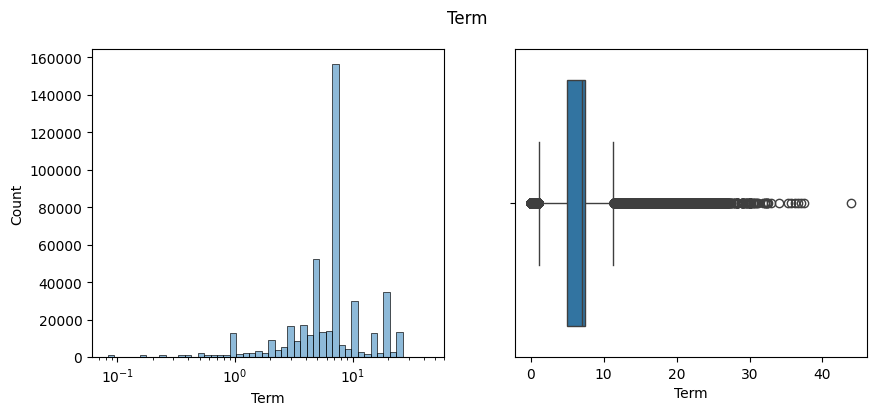

<Figure size 640x480 with 0 Axes>

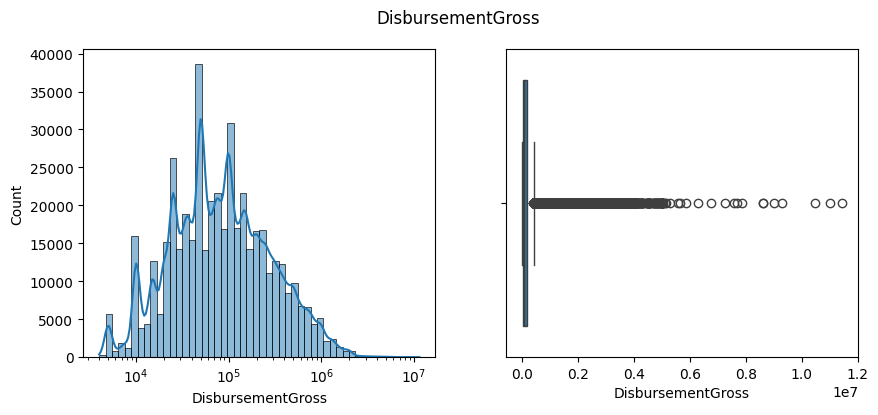

<Figure size 640x480 with 0 Axes>

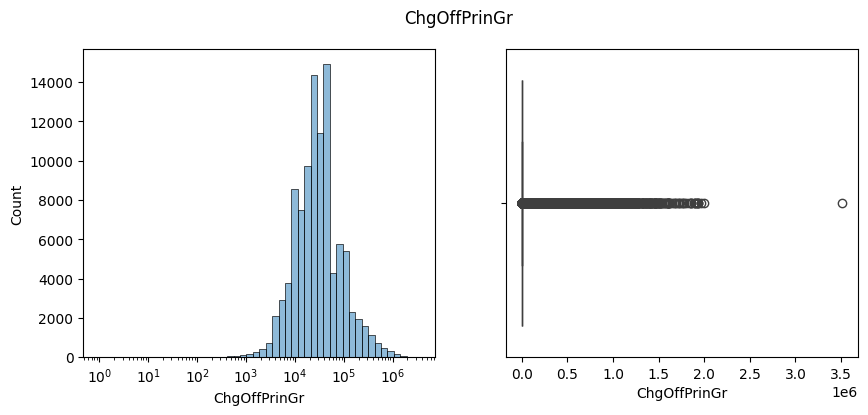

<Figure size 640x480 with 0 Axes>

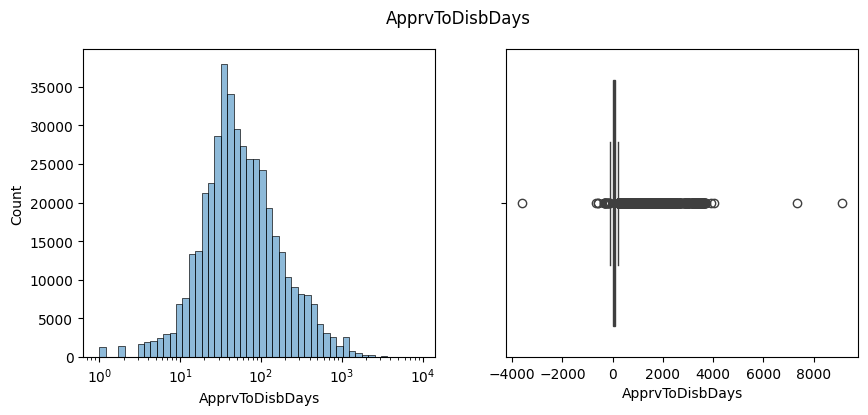

<Figure size 640x480 with 0 Axes>

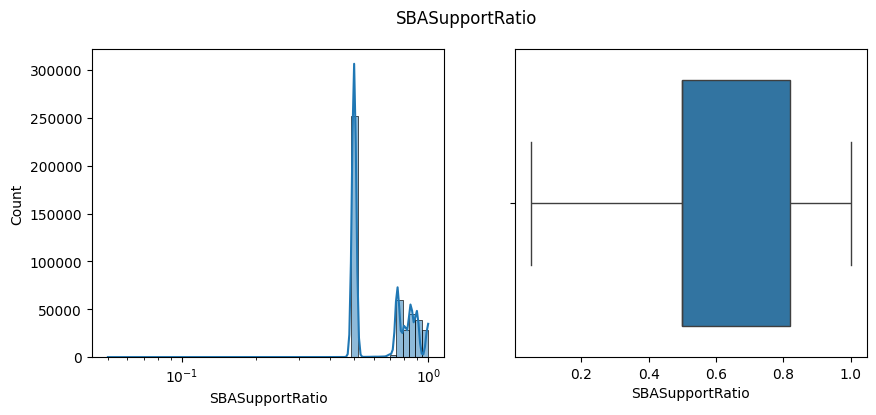

<Figure size 640x480 with 0 Axes>

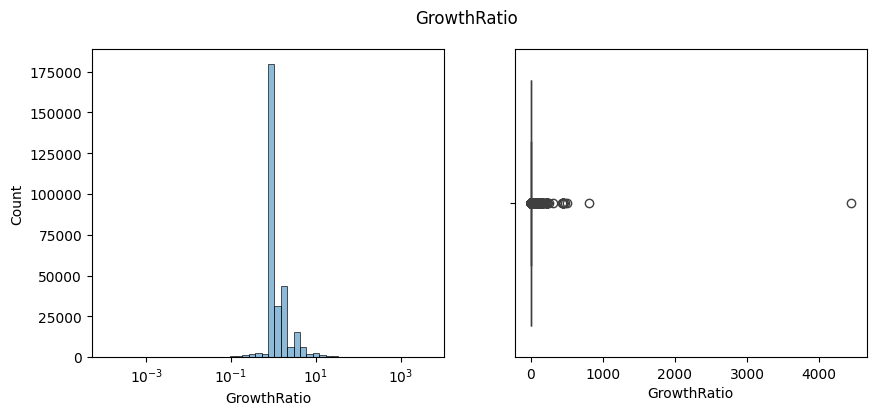

<Figure size 640x480 with 0 Axes>

In [ ]:
# Dibujamos los histogramas y los diagramas de caja de las variables numéricas para contextualizarlas
for var in variables_numericas_analisis:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=analisis_numerico, x=var, kde=True, ax=ax[0], legend=True, log_scale=True, bins=50)
    sns.boxplot(data=analisis_numerico, x=var, ax=ax[1])
    plt.suptitle(var)
    plt.show()
    plt.savefig(IMAGES_PATH + 'continuas/' + var + '.png')
    plt.close(fig)

Explicacion

## Análisis de las varaibles categóricas.

Las variables categóricas son:

In [327]:
variables_categoricas_analisis = ['NAICS', 'UrbanRural', 'NewExist', 'Franchise', 'RevLineCr', 'LowDoc', 'MIS_Status', 'ApprovalFY', 'State', 'BankState']
analisis_categorico = dataset_analisis.loc[:, variables_categoricas_analisis]

In [343]:
analisis_categorico.describe(include='all')

NAICS     UrbanRural  NewExist      Franchise RevLineCr  LowDoc  \
count      456948  456948.000000    456948  456948.000000    456948  456948   
unique         20            NaN         2            NaN         2       2   
top     Minorista            NaN  Existing            NaN         N       N   
freq        80953            NaN    335829            NaN    265007  431845   
mean          NaN       0.900588       NaN       0.031214       NaN     NaN   
std           NaN       0.604302       NaN       0.173895       NaN     NaN   
min           NaN       0.000000       NaN       0.000000       NaN     NaN   
25%           NaN       1.000000       NaN       0.000000       NaN     NaN   
50%           NaN       1.000000       NaN       0.000000       NaN     NaN   
75%           NaN       1.000000       NaN       0.000000       NaN     NaN   
max           NaN       2.000000       NaN       1.000000       NaN     NaN   

       MIS_Status ApprovalFY   State BankState  
count      456948     456948  456948    456948  
unique          2         29      51        54  
top         P I F       2007      CA        NC  
freq       358565      57028   61387     56407  
mean          NaN        NaN     NaN       NaN  
std           NaN        NaN     NaN       NaN  
min           NaN        NaN     NaN       NaN  
25%           NaN        NaN     NaN       NaN  
50%           NaN        NaN     NaN       NaN  
75%           NaN        NaN     NaN       NaN  
max           NaN        NaN     NaN       NaN

In [367]:
# Creamos un DataFrame para almacenar las estadísticas de las variables categoricas. Simulamos el describe de las variables categóricas
df_stats_categorical = pd.DataFrame(columns=['Count', 'Unique', 'Top', 'Freq'], index=variables_categoricas_analisis)

# Extraemos del describe de las variables categóricas numerizadas el conteo de valores, para ahorrar el cálculo
describe_categorical = analisis_categorico.describe()
aux = df_stats_categorical['Count'].apply(lambda x : 456948 if True else 456948)
df_stats_categorical['Count'] = aux

# Extraemos el resto de estadísticas
for var in variables_categoricas_analisis:
    
    # Extraemos  los distintos valores y sus frecuencias
    typeValueCounts = dataset_analisis[var].value_counts()
    # La longitud de la lista de etiquetas es el número de valores únicos
    df_stats_categorical.loc[var,'Unique'] = typeValueCounts.index.size
    # Extraemos el valor más frecuente y su frecuencia y lo almacenamos en el DataFrame
    maximumLabel, maximumValue = typeValueCounts.idxmax(), typeValueCounts.max()
    df_stats_categorical.loc[var,'Top'] = maximumLabel
    df_stats_categorical.loc[var,'Freq'] = maximumValue

df_stats_categorical

Count Unique        Top    Freq
NAICS       456948     20  Minorista   80953
UrbanRural  456948      3          1  285564
NewExist    456948      2   Existing  335829
Franchise   456948      2        0.0  442685
RevLineCr   456948      2          N  265007
LowDoc      456948      2          N  431845
MIS_Status  456948      2      P I F  358565
ApprovalFY  456948     29       2007   57028
State       456948     51         CA   61387
BankState   456948     54         NC   56407

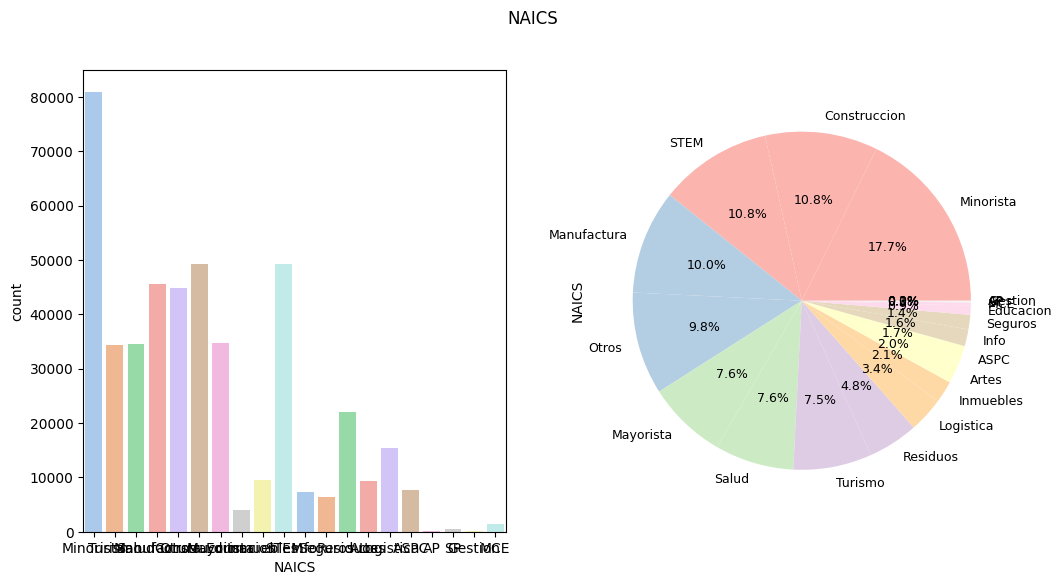

<Figure size 640x480 with 0 Axes>

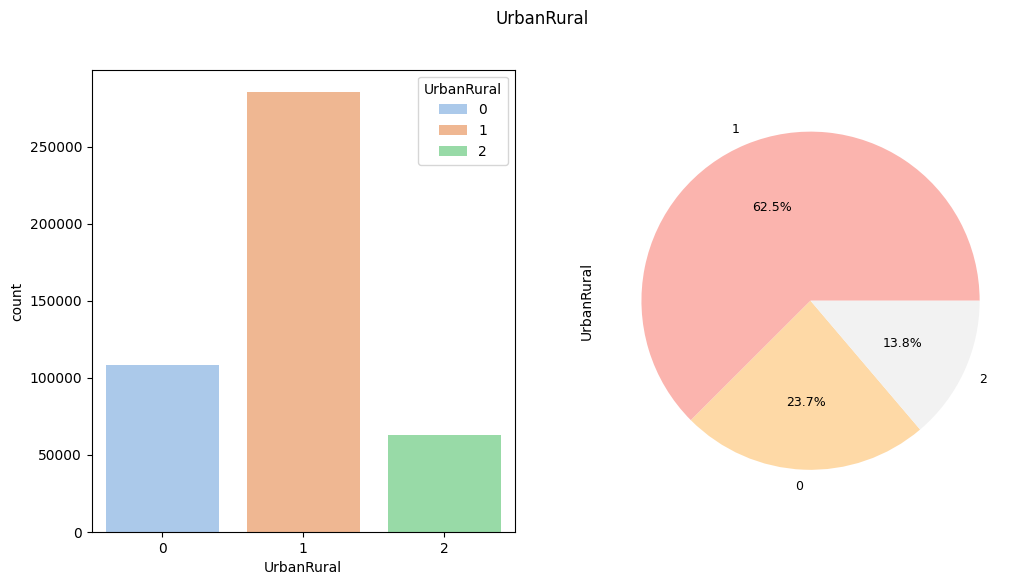

<Figure size 640x480 with 0 Axes>

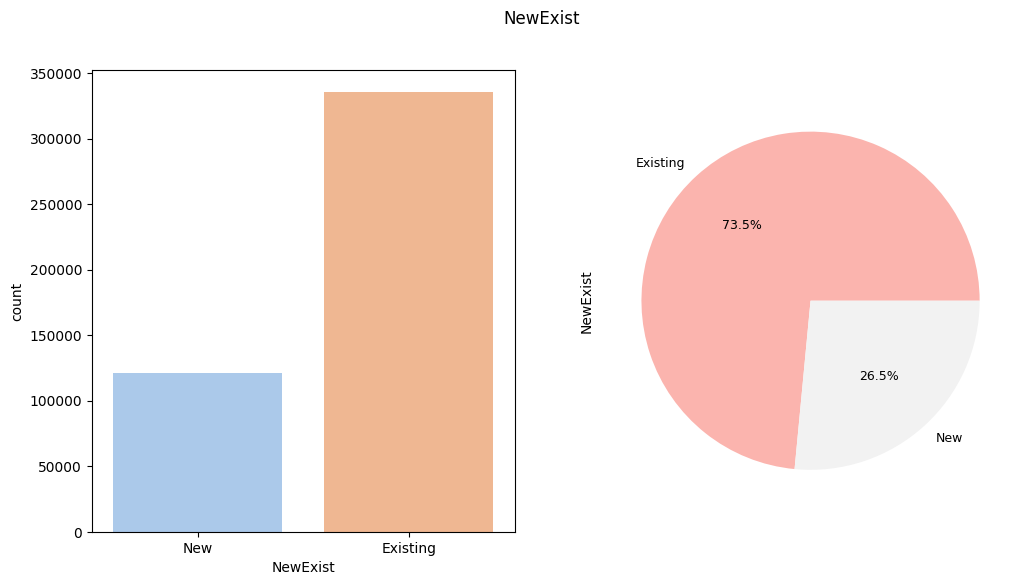

<Figure size 640x480 with 0 Axes>

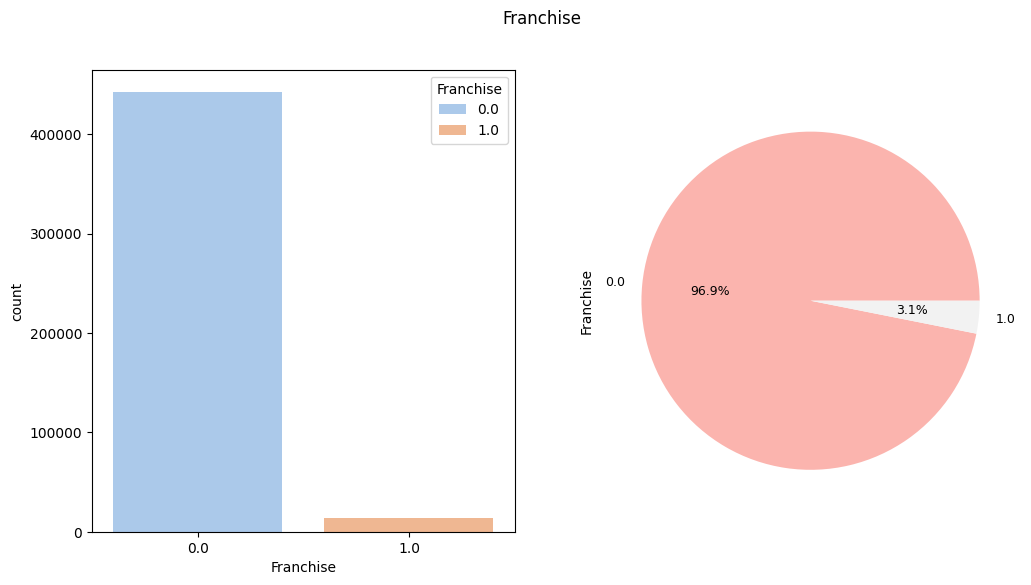

<Figure size 640x480 with 0 Axes>

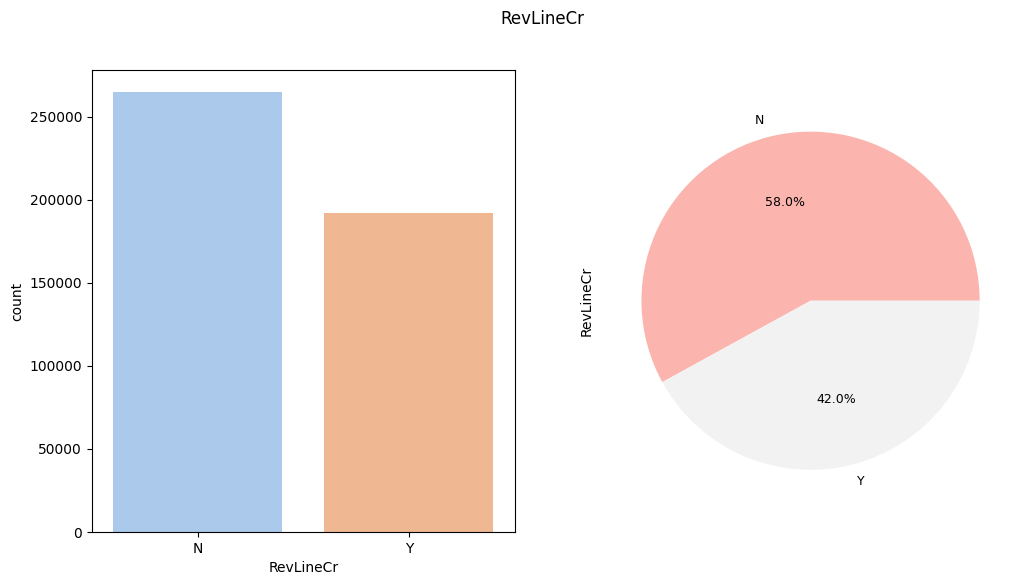

<Figure size 640x480 with 0 Axes>

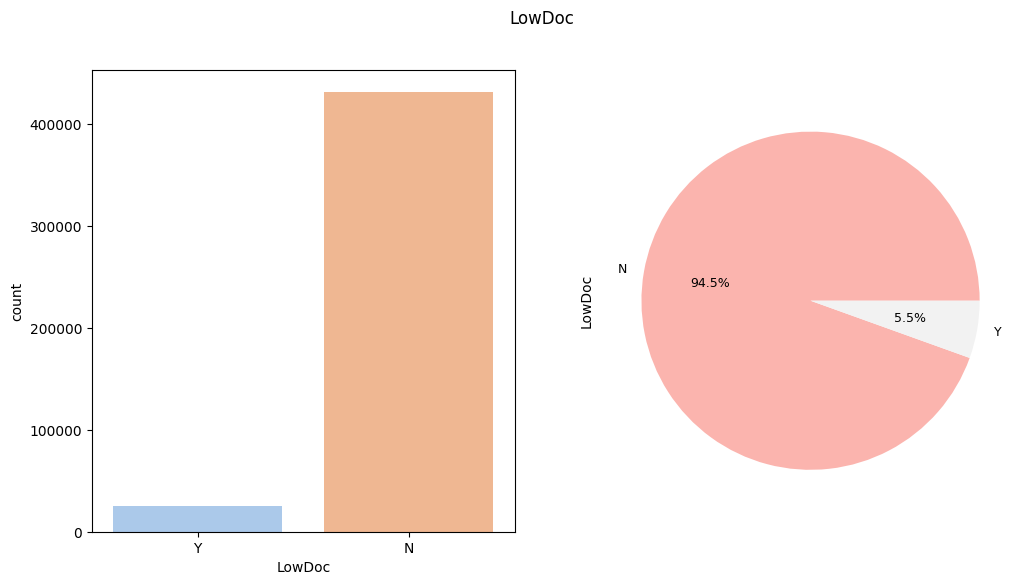

<Figure size 640x480 with 0 Axes>

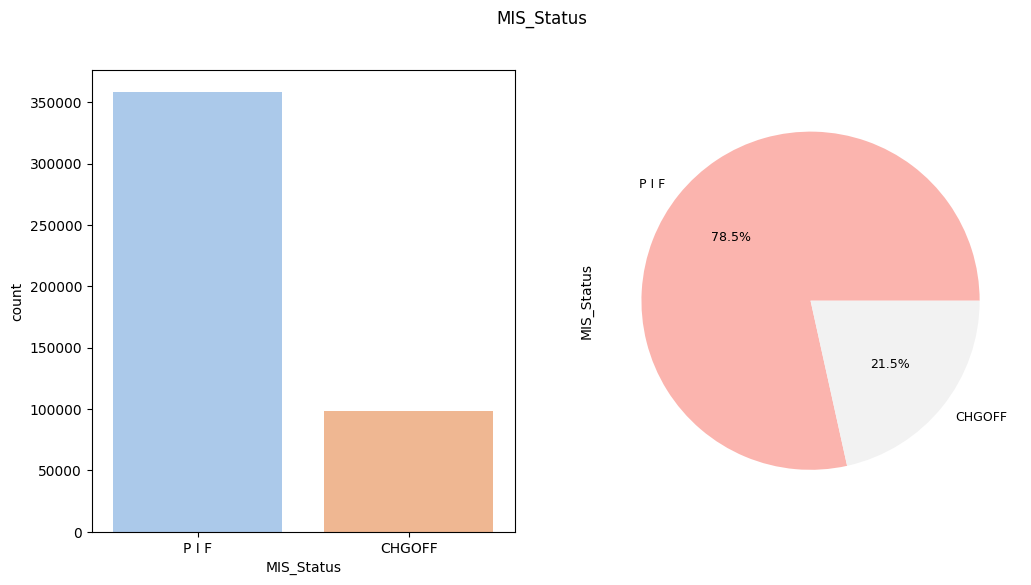

<Figure size 640x480 with 0 Axes>

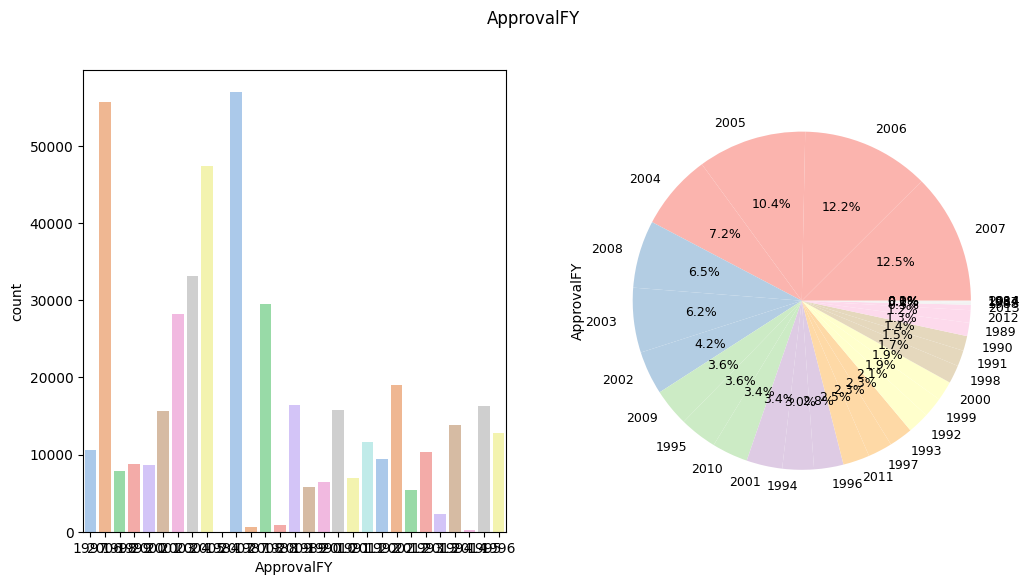

<Figure size 640x480 with 0 Axes>

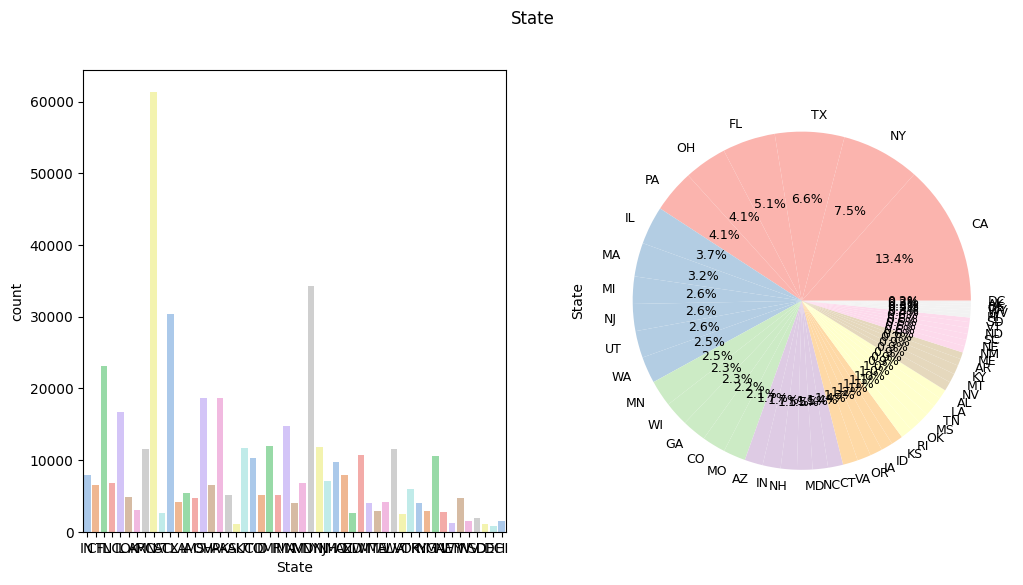

<Figure size 640x480 with 0 Axes>

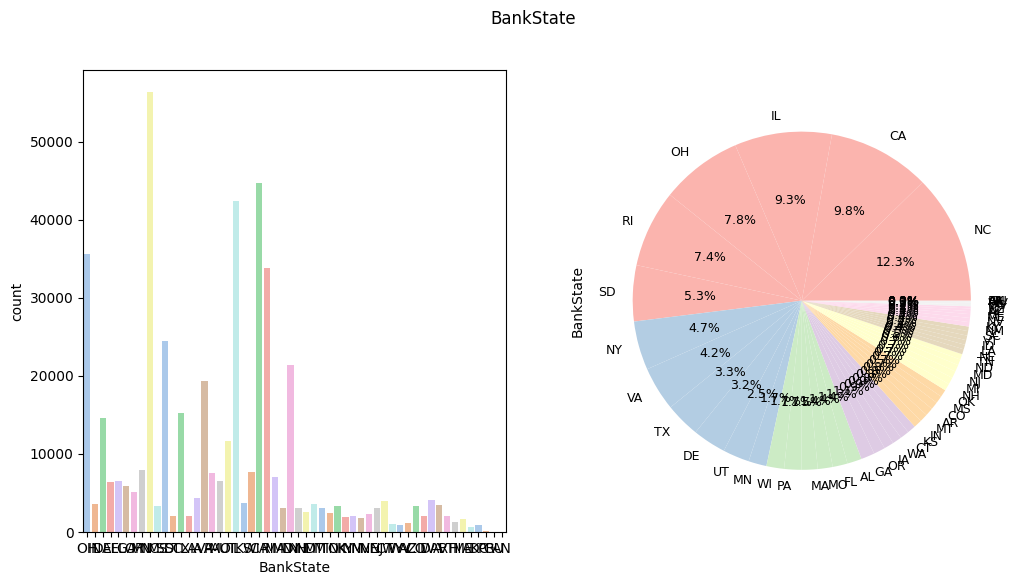

<Figure size 640x480 with 0 Axes>

In [ ]:
# Dibujamos los histogramas y los diagramas de barras y de sectores de las variables numéricas para contextualizarlas
for var in variables_categoricas_analisis:
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Diagrama de barras con función de conteo para variables categóricas
    sns.countplot(data=dataset_analisis, x=var, ax=ax[0], hue=var, palette='pastel')
    # Diagrama de sectores
    dataset_analisis[var].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], cmap='Pastel1', fontsize=9)
    plt.suptitle(var)
    plt.show()
    plt.savefig(IMAGES_PATH + 'categoricas/' + var + '.png')
    plt.close(fig)

### Etiqueta de las variables categóricas
Transformamos los datos categóricos necesarios a numéricos, usando el LabelEncoder. Principalmente por evitar el exceso de variables

In [ ]:
variables_etiquetar = ['NAICS', 'NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'ApprovalFY', 'State', 'BankState']

In [372]:
dataset_numerico = dataset_analisis.copy()
labeller = LabelEncoder()
for var in variables_etiquetar:
    dataset_numerico[var] = labeller.fit_transform(dataset_numerico[var])
    print(f"Variable {var} etiquetada. Valores únicos: {dataset_numerico[var].unique()}")

Variable NAICS etiquetada. Valores únicos: [12 19 17 10 13  3 11  4  7 16  6 18 14  2  8  1  0 15  5  9]
Variable NewExist etiquetada. Valores únicos: [1 0]
Variable RevLineCr etiquetada. Valores únicos: [0 1]
Variable LowDoc etiquetada. Valores únicos: [1 0]
Variable MIS_Status etiquetada. Valores únicos: [1 0]
Variable ApprovalFY etiquetada. Valores únicos: [11 20 12 13 14 15 17 18 19  0 21  1 22  2 23  3  4 24  5 25  6 16 26  7
 27  8 28  9 10]
Variable State etiquetada. Valores únicos: [15  6  9 27 14 36  2 23  4 40 43 18 12 25 35 45 38 16  0 44  5 13 22 39
 19 33 20 34 31 30 24  3 28 48 26 21  1 47 46 37 17 32 10 29 50 42 49 41
  8  7 11]
Variable BankState etiquetada. Valores únicos: [37 17  9  1 10 11 39 25 29 27 44 43 46 20 14 48 40 26 47 16 18 51  5 42
 21 22 36 32 30 28 24 45 38 19 34 35 31 33  7 53 52  4  6 15 50  3 49 13
 23  0  8 41 12  2]


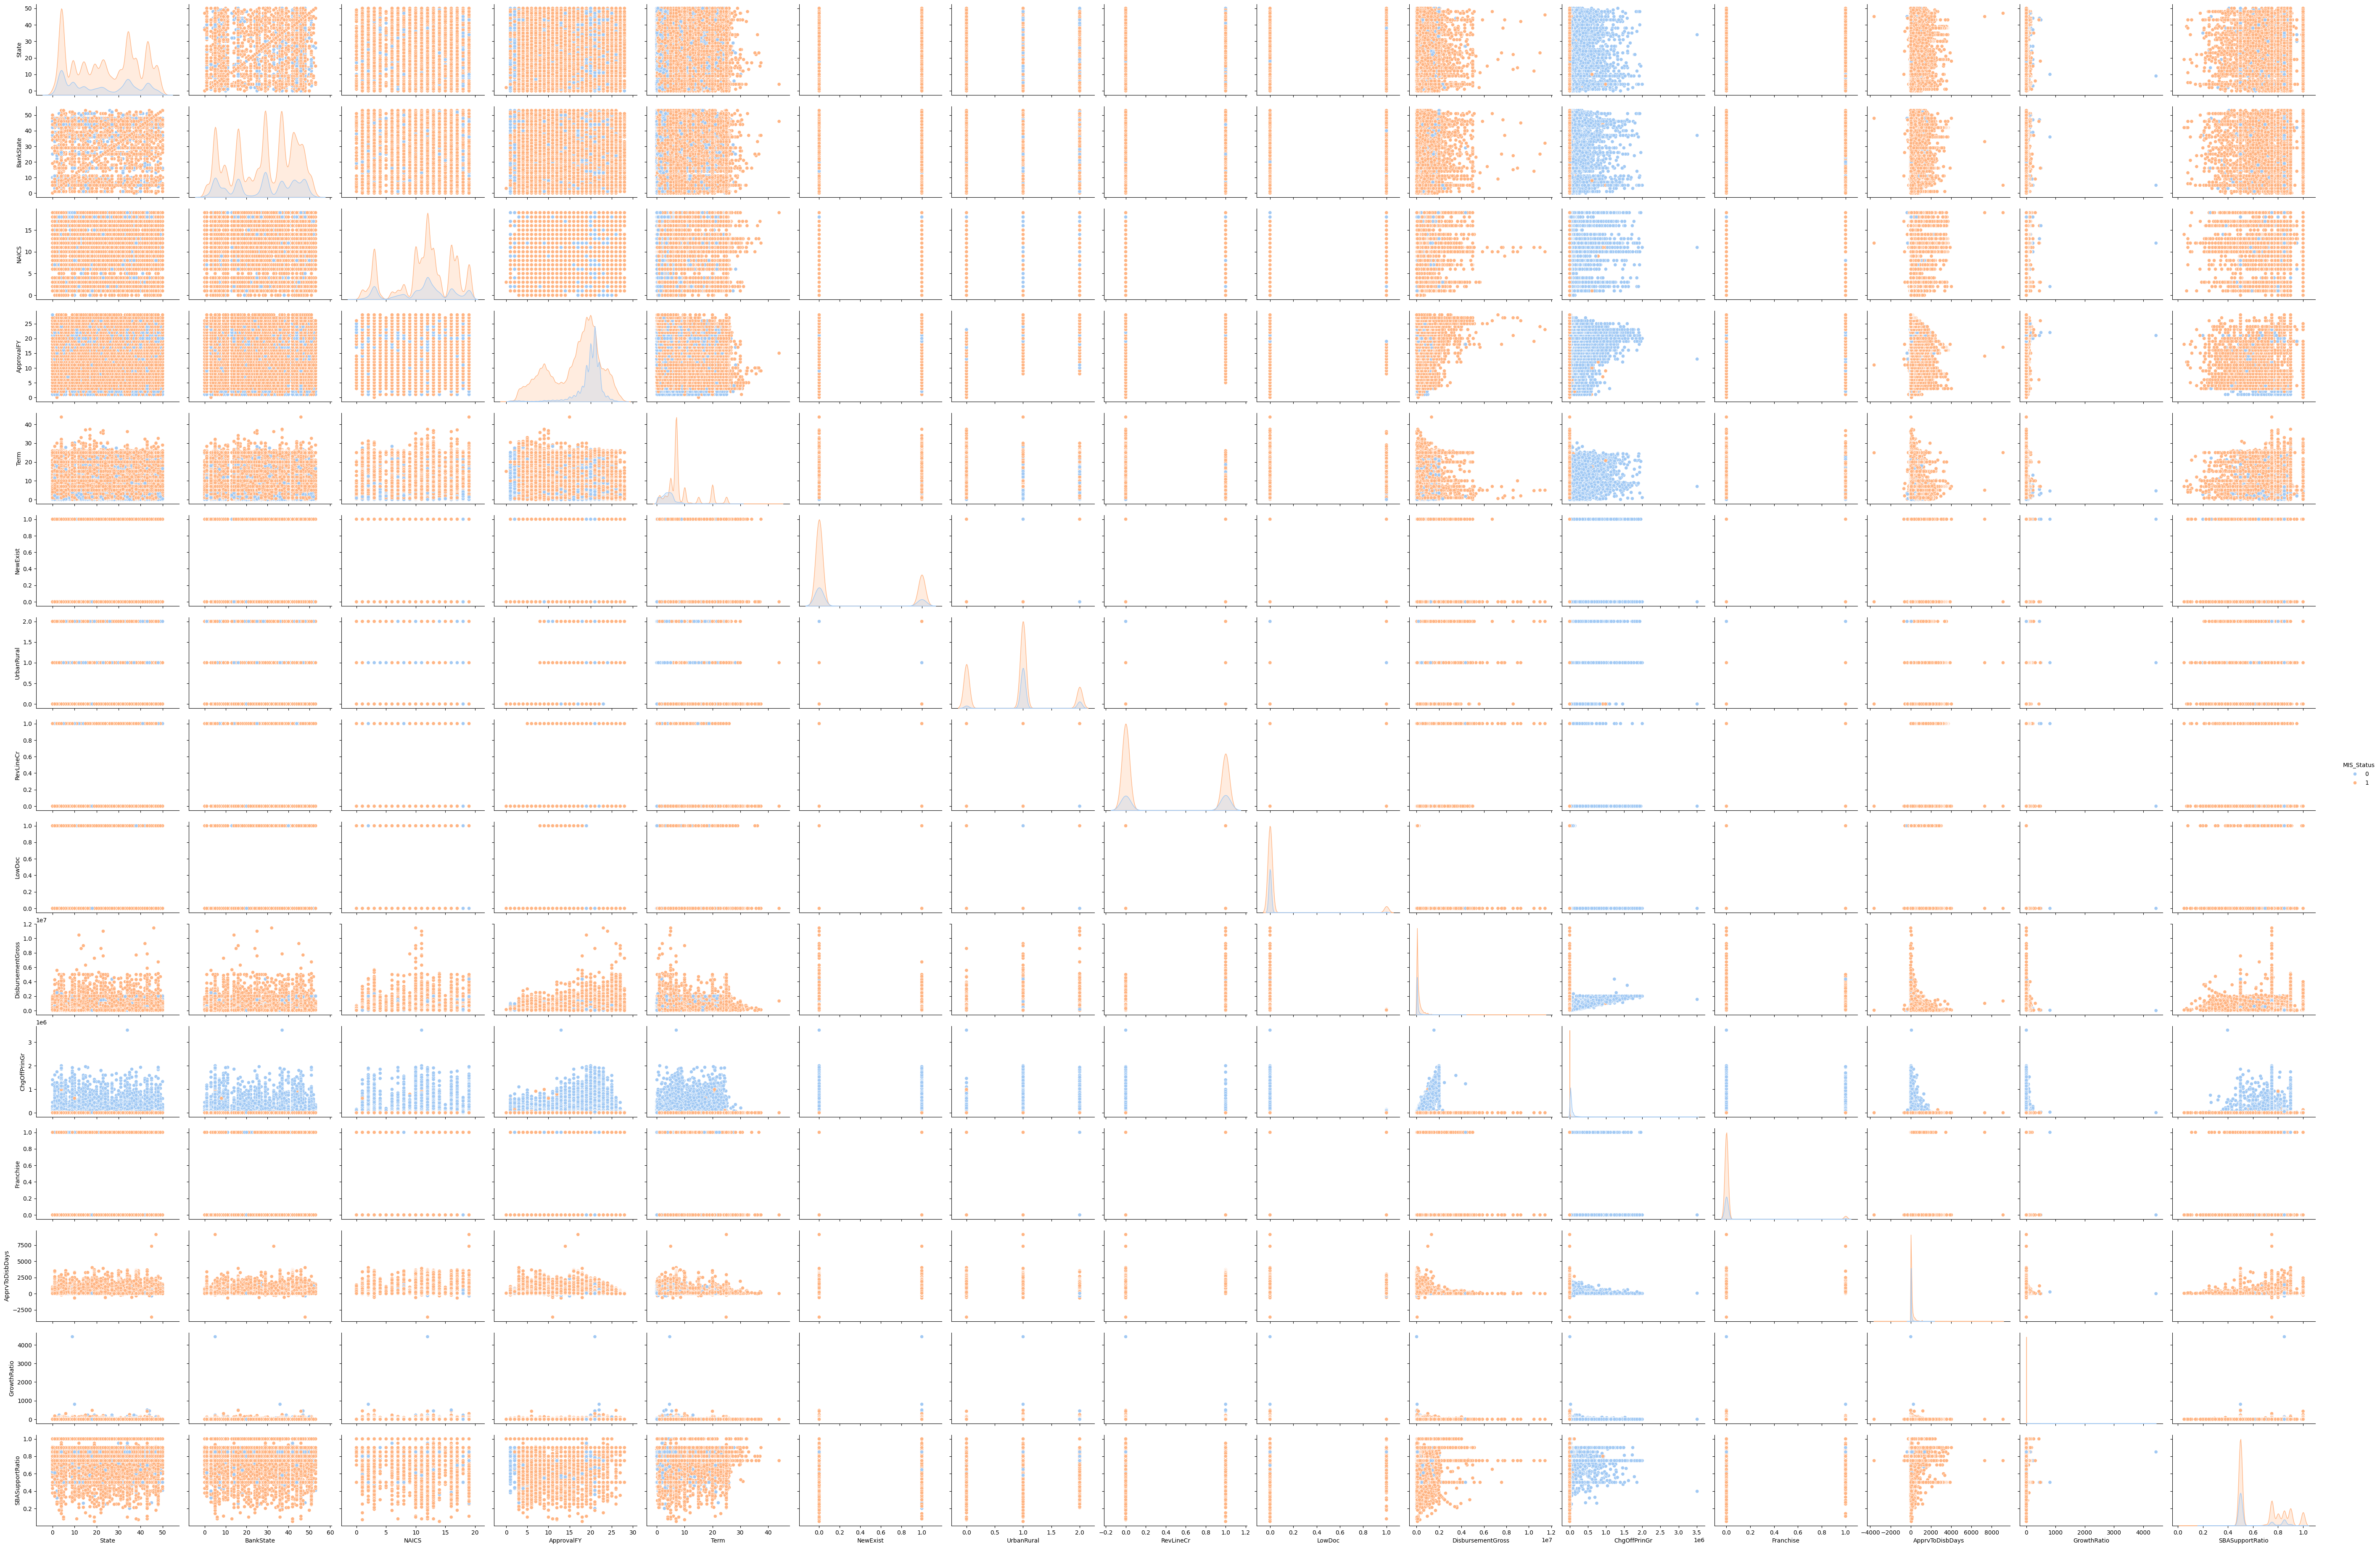

In [ ]:
sns.pairplot(dataset_numerico, hue='MIS_Status', diag_kind='kde', palette='pastel', height=2.5, aspect=1.5)
plt.show()
plt.savefig(IMAGES_PATH + 'pairplot.png')
plt.close()
#128 minutos

<Axes: >

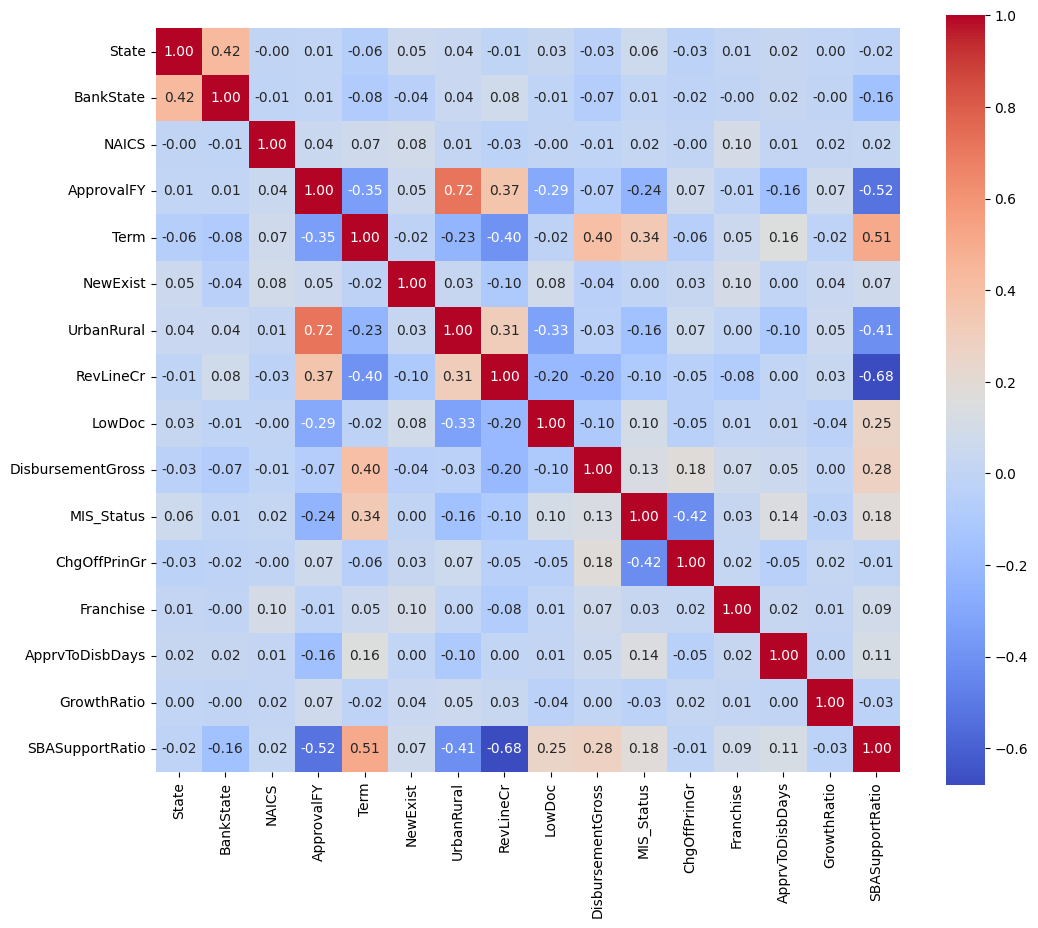

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataset_numerico.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Matriz de correlación')
plt.show()
plt.savefig(IMAGES_PATH + 'heatmap.png')
plt.close()

In [ ]:
variables_correlacionadas = ['ApprovalFY', 'Term', 'UrbanRural', 'RevLineCr', 'LowDoc' 'DisbursementGross', 'ChgOffPrinGr', 'SBASupportRatio']
variables_sin_correlacion = ['NAICS', 'NewExist', 'Franchise', 'GrowthRatio', 'ApprvToDisbDays', 'State', 'BankState']

In [ ]:
dataset = dataset_numerico.drop(columns=variables_sin_correlacion)
dataset.reset_index(drop=True, inplace=True)


df = dataset.drop(columns=['MIS_Status']).copy(deep=True)
df.reset_index(drop=True, inplace=True)


In [386]:
dataset.to_csv(DATA_PATH + 'SBAFiltered.csv', index=False)

### Escalado de los datos

In [397]:
std = StandardScaler()

In [398]:
df_std = pd.DataFrame(std.fit_transform(df), columns=df.columns)
df_std.describe(include='all')

State     BankState    ApprovalFY          Term    UrbanRural  \
count  4.569480e+05  4.569480e+05  4.569480e+05  4.569480e+05  4.569480e+05   
mean  -4.969700e-17  3.980736e-18 -7.563399e-17 -6.195021e-16 -4.776883e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -1.607772e+00 -1.915850e+00 -3.008750e+00 -1.372262e+00 -1.490298e+00   
25%   -1.003661e+00 -8.299648e-01 -5.339690e-01 -5.092114e-01  1.645070e-01   
50%    3.192182e-03  5.231721e-02  3.498813e-01 -1.435119e-01  1.645070e-01   
75%    8.757980e-01  9.345992e-01  7.034214e-01 -5.574403e-02  1.645070e-01   
max    1.748404e+00  1.681146e+00  1.940812e+00  6.336683e+00  1.819312e+00   

          RevLineCr        LowDoc  DisbursementGross  ChgOffPrinGr  \
count  4.569480e+05  4.569480e+05       4.569480e+05  4.569480e+05   
mean  -3.184589e-17  2.388442e-17       5.150077e-17 -5.224716e-17   
std    1.000001e+00  1.000001e+00       1.000001e+00  1.000001e+00   
min   -8.510503e-01 -2.411009e-01      -6.112453e-01 -2.226852e-01   
25%   -8.510503e-01 -2.411009e-01      -4.985646e-01 -2.226852e-01   
50%   -8.510503e-01 -2.411009e-01      -3.503914e-01 -2.226852e-01   
75%    1.175019e+00 -2.411009e-01       7.210818e-02 -2.226852e-01   
max    1.175019e+00  4.147641e+00       4.097999e+01  6.025731e+01   

       SBASupportRatio  
count     4.569480e+05  
mean     -9.235308e-16  
std       1.000001e+00  
min      -3.359509e+00  
25%      -8.502205e-01  
50%      -8.502205e-01  
75%       9.297508e-01  
max       1.937878e+00

In [399]:
df_std.to_csv(DATA_PATH + 'SBAStandarized.csv', index=False)

## Modelos

In [3]:
dataset = pd.read_csv(DATA_PATH + 'SBAFiltered.csv', low_memory=False)
df_std = pd.read_csv(DATA_PATH + 'SBAStandarized.csv', low_memory=False)

In [4]:
x = df_std.copy(deep=True)
y = dataset['MIS_Status'].copy(deep=True)
y.reset_index(drop=True, inplace=True)

Entonces en `df_std`e `y` estarán todos los datos que necesitaremos.


In [ ]:
"""# 1. Separar características (X) y etiqueta (y)
X = original_dataset.drop('MIS_Status', axis=1)
y = original_dataset['MIS_Status']

# 2. Dividir en conjunto de entrenamiento y test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Tamaño de Train: {X_train.shape}')
print(f'Tamaño de Test: {X_test.shape}')
"""

In [ ]:
"""# 1. Entrenar un modelo de Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# 2. Predicciones
y_pred_logreg = logreg.predict(X_test)

# 3. Evaluar el modelo
print("Resultados - Regresión Logística:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_logreg):.4f}")"""

## Inteligencia Artificial Explicable (xAI)